## Assignment 6: Bayesian Statistics and Markov Chain Monte Carlo

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

### Problem 1

Suppose you have an algorithm to identify [quasars](https://en.wikipedia.org/wiki/Quasar) from astronomical images, which simply returns `True` or `False`. Using control samples, you have determined that your algorithm has the following performance for real quasars as well as the main contaminants for a quasar sample: galaxies and stars.

| data? | M=quasar | M=galaxy | M=star |
|---|--------|--------|------|
| D=True  |  0.8   |   0.1  |  0.2 |
| D=False |  0.2   |   0.9  |  0.8 |

Implement the following function to calculate the likelihood $P(D\mid M)$ given this information:

In [2]:
def likelihood(D, M):
    """Calculate likelihood of data D given model M.
    
    Parameters
    ----------
    D : bool
        A boolean (True/False) value indicating whether the algorithm identified an
        object as being a quasar or not.
    M : str
        A string ('quasar', 'galaxy', 'star') specifying the assumed model.
        
    Returns
    -------
    float
        The probability of the data given the model.
    """
    ### BEGIN SOLUTION
    if M == 'quasar':
        return 0.8 if D else 0.2
    elif M == 'galaxy':
        return 0.1 if D else 0.9
    elif M == 'star':
        return 0.2 if D else 0.8
    ### END SOLUTION

In [3]:
# A correct solution should pass these tests.
assert likelihood(True, 'quasar') == 0.8
assert likelihood(False, 'galaxy') == 0.9
assert likelihood(True, 'star') == 0.2
for M in 'quasar', 'galaxy', 'star':
    assert likelihood(True, M) + likelihood(False, M) == 1

The prior probability of each model will vary between images, depending mostly on the local density of stars which can vary a lot (and is especially high when you look through the disk of the Milky Way).

Implement the function below to calculate the prior probabilities of each model for an image based on the expected number of objects of each type:

In [4]:
def prior(num_quasars_expected, num_galaxies_expected, num_stars_expected):
    """Calculate the prior probability of each model.
    
    Parameters
    ----------
    num_quasars_expected : int
        Number of expected quasars.
    num_galaxies_expected : int
        Number of expected galaxies.
    num_stars_expected : int
        Number of expected stars.
    
    Returns
    -------
    dict
        Dictionary of prior probabilities for each model with keys 'quasar',
        'galaxy' and 'star'.
    """
    ### BEGIN SOLUTION
    total_expected = num_quasars_expected + num_galaxies_expected + num_stars_expected
    return {
        'quasar': num_quasars_expected / total_expected,
        'galaxy': num_galaxies_expected / total_expected,
        'star': num_stars_expected / total_expected }
    ### END SOLUTION

In [5]:
# A correct solution should pass these tests.
assert prior(100, 100, 200) == {'quasar': 0.25, 'galaxy': 0.25, 'star': 0.5}
assert prior(100, 100, 600) == {'quasar': 0.125, 'galaxy': 0.125, 'star': 0.75}

You have now the code necessary to quantify how well your quasar identification algorithm performs in regions with different densities of stars, using the posterior probability $P(\text{quasar}\mid \text{True})$.  For example, if the stellar density increases 3 times (from 200 to 600 per image) with fixed quasar and galaxy densities (100 each), the posterior probability drops from 0.615 to 0.381:

In [6]:
from mls import Learn

In [7]:
Learn(prior(100, 100, 200), likelihood, True)
Learn(prior(100, 100, 600), likelihood, True)

,galaxy,quasar,star
PRIOR,0.250,0.250,0.500
D=True,0.077,0.615,0.308


,galaxy,quasar,star
PRIOR,0.125,0.125,0.750
D=True,0.048,0.381,0.571


### Problem 2

Suppose you measure a random process that follows an [exponential decay law](https://en.wikipedia.org/wiki/Exponential_decay) for the number $n(t)$ of un-decayed states as a function of time $t$:
$$
\frac{dn}{dt} = -\lambda n \; ,
$$
and want to infer the posterior probability of the decay rate $\lambda$ given your data.

First, implement the function below to evaluate the likelihood of observing $N$ decay times $D = \{t_1, t_2, \ldots\}$ as:
$$
P(D\mid \lambda) = \prod_{i=1}^{N}\, P(t_i\mid \lambda)
$$
where the **un-normalized** probability density for exponential decay is:
$$
P(t\mid \lambda) \propto \exp(-\lambda t) \; .
$$

In [8]:
def decay_likelihood(decay_times, lam):
    """Calculate the normalized likelihood of measured times assuming a decay rate.
    """
    ### BEGIN SOLUTION
    N = len(decay_times)
    return lam ** N * np.exp(-lam * np.sum(decay_times))
    ### END SOLUTION

In [9]:
# A correct solution should pass these tests.
assert decay_likelihood([], 1) == 1
assert np.round(decay_likelihood([1], 0.1), 4) == 0.0905
assert np.round(decay_likelihood([1], 1.0), 4) == 0.3679
assert np.round(decay_likelihood([1], 1.5), 4) == 0.3347
assert np.round(decay_likelihood([1,2,1], 0.1), 4) == 0.0007
assert np.round(decay_likelihood([1,2,1], 1.0), 4) == 0.0183
assert np.round(decay_likelihood([1,2,1], 1.5), 4) == 0.0084

For our prior, we use the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), which has two hyperparameters $\alpha$ and $\beta$:
$$
P(\lambda\mid \alpha,\beta) = \frac{\beta^\alpha \lambda^{\alpha-1} e^{-\beta\lambda}}{\Gamma(\alpha)} \; .
$$
Implement the function below to evaluate the Gamma distribtion PDF using a numpy expression for the numerator and [scipy.special.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html) for the denominator:

In [10]:
import scipy.special

def gamma_distribution(lam, alpha, beta):
    """Evaluate the gamma distribution.
    """
    ### BEGIN SOLUTION
    return beta ** alpha * lam ** (alpha - 1) * np.exp(-beta * lam) / scipy.special.gamma(alpha)
    ### END SOLUTION

In [11]:
# A correct solution should pass these tests.
import scipy.stats
assert gamma_distribution(1, 0, 1) == 0
assert gamma_distribution(1, 1, 0) == 0
for lam in (0.1, 1, 2):
    for alpha, beta in (1, 1), (2, 1), (2, 2):
        assert np.allclose(
            gamma_distribution(lam, alpha, beta),
            scipy.stats.gamma.pdf(lam, a=alpha, scale=1/beta))

The advantage of this choice of prior is that the evidence integral can be performed analytically:
$$
P(D\mid \alpha,\beta) = \int d\lambda\, P(D\mid\lambda)\, P(P(\lambda\mid \alpha,\beta)
= \frac{\beta^\alpha (\beta + T)^{-(\alpha+N)} \Gamma(\alpha+N)}{\Gamma(\alpha)} \; .
$$
Use this result to convince yourself that the posterior $P(\lambda\mid D,\alpha,\beta)$ is another Gamma distribution, but with different hyperparameter values $\alpha'$ and $\beta'$.  Priors and posteriors with the same functional form for some likelihood are called [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior). The `binomial_learn` example in class also used conjugate priors.

Implement the function below to learn from measured decay times by updating the prior hyperparameters:

In [12]:
def rate_learn(prior_alpha, prior_beta, decay_times):
    """Learn from data to update hyperparameters.
    
    Parameters
    ----------
    prior_alpha : float
        Hyperparameter alpha for the prior Gamma distribution PDF.
    prior_beta : float
        Hyperparameter beta for the prior Gamma distribution PDF.
    decay_times : array
        Array of observed decay times.
        
    Returns
    -------
    tuple
        Tuple (post_alpha, post_beta) of hyperparameter values for the
        posterior Gamma distribution PDF.
    """
    ### BEGIN SOLUTION
    N = len(decay_times)
    return prior_alpha + N, prior_beta + np.sum(decay_times)
    ### END SOLUTION

In [13]:
# A correct solution should pass these tests.
assert rate_learn(1, 1, []) == (1, 1)
assert rate_learn(2, 1, []) == (2, 1)
assert rate_learn(1, 2, []) == (1, 2)
assert np.allclose(
    np.round(rate_learn(np.sqrt(10), np.pi, [1,2,1]), 3),
    (6.162, 7.142))

You can use the function below to test your code visually and confirm that better data reduces the influence of the prior:

In [14]:
def rate_learn_plot(prior_alpha, prior_beta, num_decays, true_lam, seed=123):
    """
    """
    # Generate some random decays using the true decay rate.
    gen = np.random.RandomState(seed=seed)
    decay_times = scipy.stats.expon.rvs(scale=1 / true_lam, size=num_decays, random_state=gen)
    
    # Use Bayes' rule to learn from the data.
    lam = np.linspace(0., 2.5 * true_lam, 250)
    prior = gamma_distribution(lam, prior_alpha, prior_beta)
    like = decay_likelihood(decay_times, lam)
    post_alpha, post_beta = rate_learn(prior_alpha, prior_beta, decay_times)
    post = gamma_distribution(lam, post_alpha, post_beta)
    
    # Plot a summary of the learning process.
    plt.fill_between(lam, prior, alpha=0.25)
    plt.plot(lam, prior, label='Prior')
    plt.plot(lam, like / np.max(like) * np.max(prior), 'k:', label='Likelihood')
    plt.fill_between(lam, post, alpha=0.25)
    plt.plot(lam, post, label='Posterior')
    plt.axvline(true_lam, c='r', ls='--')
    plt.xlabel('Decay rate $\lambda$')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.xlim(0, lam[-1])
    plt.ylim(0, None)

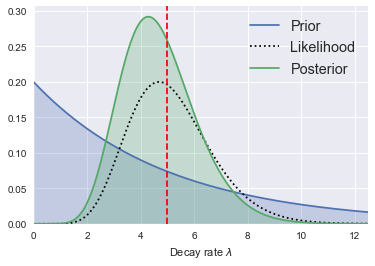

In [15]:
rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=10, true_lam=5)

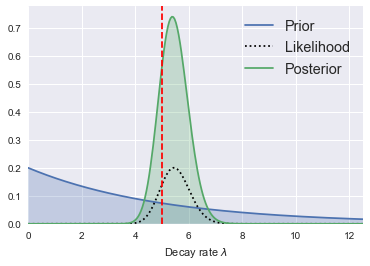

In [16]:
rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=100, true_lam=5)

### Problem 3

In this problem you will solve the same decay rate inference problem but this time using a numerical estimate based on Markov-chain Monte Carlo (MCMC).

Recall that `MCMC_sample()` generates samples using a function proportional to the desired PDF. Implement the function below to evaluate the logarithm of the un-normalized posterior probability density:
$$
\log P(D\mid \lambda) + \log P(\lambda\mid \alpha, \beta) \; .
$$
Do not call your `decay_likelihood()` or `gamma_distribution()` functions in your implementation since the result has better accuracy if you apply the logarithm and simplify analytically. Since MCMC sampling only requires a function proportional to the desired PDF, you can drop any factors in $P(D\mid \lambda)$ or $P(\lambda\mid \alpha, \beta)$ that do not depend on $\lambda$.

In [17]:
def decay_logf(lam, decay_times, prior_alpha, prior_beta):
    """Evaluate a function proportional to the log-posterior probability density.
    
    Parameters
    ----------
    lam : float
        Decay rate parameter.
    decay_times : array
        Array of observed decay times.
    prior_alpha : float
        Hyperparameter alpha for the prior Gamma distribution PDF.
    prior_beta : float
        Hyperparameter beta for the prior Gamma distribution PDF.
    
    Returns
    -------
    float
        log P(D|lam) + log P(lam|alpha,beta) up to a constant that does not
        depend on the value of lam. Returns -np.inf when lam <= 0.
    """
    ### BEGIN SOLUTION
    if lam <= 0:
        return -np.inf
    N = len(decay_times)
    log_like = N * np.log(lam) - lam * np.sum(decay_times)
    log_prior = (prior_alpha - 1) * np.log(lam) - prior_beta * lam
    return log_like + log_prior
    ### END SOLUTION

In [18]:
# A correct solution should pass these tests.
a, b = 1, 0.2
offset = decay_logf(1, [], a, b)
assert np.allclose(decay_logf(0.1, [], a, b) - offset, +0.18)
assert np.allclose(decay_logf(2, [], a, b) - offset, -0.2)
assert np.allclose(np.round(decay_logf(0.1, [1,2,1], a, b), 3) - offset, -7.128)
assert np.allclose(np.round(decay_logf(1, [1,2,1], a, b), 3) - offset, -4.000)
assert np.allclose(np.round(decay_logf(2, [1,2,1], a, b), 3) - offset, -6.121)

You can use the function below to test your numerical solution and compare with the posterior found using `rate_learn_plot` above.

In [19]:
from mls import MCMC_sample

def MCMC_rate_learn_plot(prior_alpha, prior_beta, num_decays, true_lam, seed=123):
    # Generate some random decays using the true decay rate.
    gen = np.random.RandomState(seed=seed)
    decay_times = scipy.stats.expon.rvs(scale=1 / true_lam, size=num_decays, random_state=gen)
    # Generate MCMC samples of the decay rate for this data with this prior.
    samples = MCMC_sample(decay_logf, lam=[true_lam], decay_times=decay_times,
                          prior_alpha=prior_alpha, prior_beta=prior_beta, nsamples=20000)
    # Plot samples.
    plt.hist(samples['lam'], range=(0, 2.5 * true_lam), bins=40, normed=True)
    plt.axvline(true_lam, c='r', ls='--')
    plt.xlabel('Decay rate $\lambda$')
    plt.xlim(0, 2.5 * true_lam)

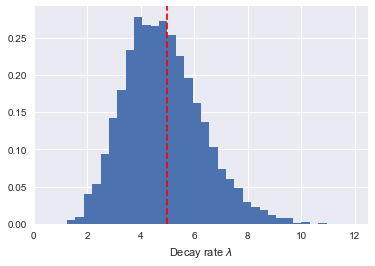

In [20]:
MCMC_rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=10, true_lam=5)

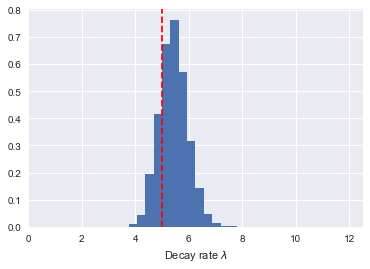

In [21]:
MCMC_rate_learn_plot(prior_alpha=1, prior_beta=0.2, num_decays=100, true_lam=5)